In [11]:
import numpy as np 
from gcs import path_handler as ph 
import stream_analysis as sa
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os 

In [12]:
dark=False
results_path=ph.paths['simulations'] + "/ImpactGeometry/pouliasis2017pii-GCNBody/Pal5"+"/AllImpactGeometryByHandAndEye.csv"

if dark==True:
    plt.style.use('dark_background')
    outname="histogram_impact_time_dark.png"
else:
    outname="histogram_impact_time.png"

In [13]:
results = pd.read_csv(results_path)
withgap=results[results['gap_flag']]

In [14]:
unique_suspects = np.unique(withgap['suspect'])
per_suspect = {}
for i,suspect in enumerate(unique_suspects):
    per_suspect[suspect]=np.array(withgap[withgap['suspect']==suspect]['T'])

In [15]:

nbins = 20
bin_edges = np.linspace(-5,0,nbins+1)
centers = (bin_edges[1:] + bin_edges[:-1]) / 2

histograms = [ ]
for i in range(len(unique_suspects)):
    hist, bins = np.histogram(per_suspect[unique_suspects[i]], bins=bin_edges)
    histograms.append(hist)
histograms = np.array(histograms)

# Sort and stack histograms
# sorted_indices = np.argsort(-histograms, axis=0)  # Sort in descending order
sorted_histograms = np.zeros_like(histograms)
for i in range(nbins):
    sorted_histograms[:, i] = histograms[:, i]

cmap = cm.get_cmap('tab20', len(unique_suspects))  # 'tab20' is a colormap with 20 distinct colors


/tmp/ipykernel_71606/142194680.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(unique_suspects))  # 'tab20' is a colormap with 20 distinct colors


In [16]:
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use 'serif' or specify the exact font family
    "font.serif": ["Times New Roman"],  # Replace with the font used in your LaTeX document
    "axes.labelsize": 12,  # Font size for axis labels
    "font.size": 12,  # General font size
    "legend.fontsize": 12,  # Font size for legend
    "xtick.labelsize": 12,  # Font size for x-axis tick labels
    "ytick.labelsize": 12,  # Font size for y-axis tick labels
})

In [17]:
text_properties = dict(
    ha='left', 
    va='bottom', 
    fontsize=8, 
    rotation=50)

axis_properties = dict(
    xlabel='Time of impact [s kpc / km]', 
    ylabel='Number of impacts', )

axis1_properties = dict(
    yticks= [40, 42, 44])


Saved to  ../paper/histogram_impact_time.png


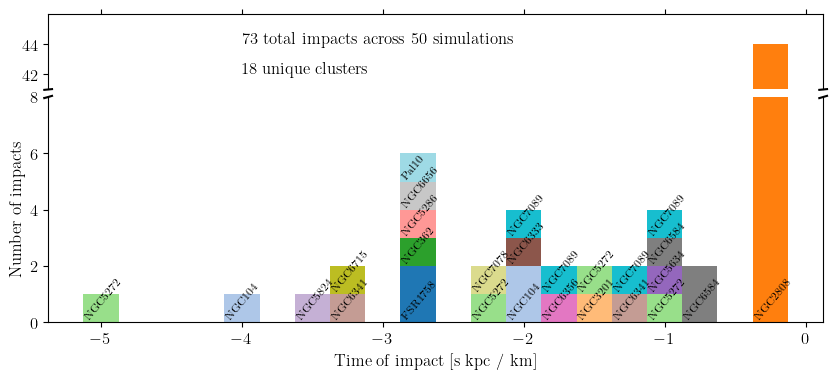

In [18]:

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10, 4),sharex=True,gridspec_kw={'height_ratios': [1, 3], 'hspace': 0.05})
dy=1.5
dx = bin_edges[1]-bin_edges[0]
# do it one bin at a time,
for j in range(nbins):
    present_suspects=np.where(histograms[:,j]>0)[0]
    sort_indexes =np.argsort(histograms[present_suspects,j])[::-1]
    for i in range(len(present_suspects)):
        ax2.bar(bin_edges[j], histograms[present_suspects[sort_indexes[i]], j], width=dx, bottom=np.sum(histograms[present_suspects[sort_indexes[:i]], j]), color=cmap(present_suspects[i]), label=unique_suspects[present_suspects[sort_indexes[i]]])
        ax1.bar(bin_edges[j], histograms[present_suspects[sort_indexes[i]], j], width=dx, bottom=np.sum(histograms[present_suspects[sort_indexes[:i]], j]), color=cmap(present_suspects[i]), label=unique_suspects[present_suspects[sort_indexes[i]]])
        
    bottom = np.sum(histograms[present_suspects[sort_indexes[:]], j])

    for i in range(len(present_suspects)):
        ypos = bottom + i*dy
        ypos = np.sum(histograms[present_suspects[sort_indexes[:i]], j])
        ax2.text(bin_edges[j] - dx/2  , ypos, unique_suspects[present_suspects[i]],**text_properties )
ax2.set(**axis_properties)
ax1.set(**axis1_properties)
ax2.set_ylim(0, 8)


# BREAK THE Y-AXIS
ax1.set_ylim(41, 46)


ax1.text(-4,44,"{:d} total impacts across {:d} simulations".format(len(withgap),50),fontsize=12)
ax1.text(-4,42,"{:d} unique clusters".format(len(unique_suspects),50),fontsize=12)

# Hide the spines between the two plots
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # Don't put tick labels at the top
ax2.xaxis.tick_bottom()
# Add diagonal lines to indicate the break
d = .005  # How big to make the diagonal lines in axes coordinates
color="k"
if dark==True:
    color="white"
kwargs = dict(transform=ax1.transAxes, clip_on=False,color=color)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # Top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal

kwargs.update(transform=ax2.transAxes)  # Switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

outdir="../paper"
os.makedirs(outdir,exist_ok=True)
fig.savefig(outdir+"/"+outname,dpi=300)
print("Saved to ",outdir+"/"+outname)

8 are on the trailing tail and 21 on the leading tail, but this is normal, right?

In [30]:
from scipy import stats
import numpy as np 
import matplotlib.pyplot as plt

In [7]:
n = 29
p = 1/2
k = 8
mydist=stats.binom(n=n,p=p)

In [35]:
k

8

In [48]:
print(mydist.cdf(k)*100)

1.205977238714695


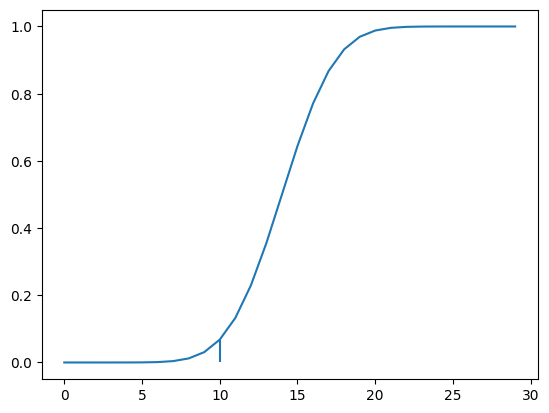

In [41]:
xs=np.arange(0,n+1)
plt.plot(xs,mydist.cdf(xs))
plt.vlines(k,0,mydist.cdf(k))